In [1]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 5.0 MB/s 


In [2]:
!pip install ipdb

     |████████████████████████████████| 790 kB 5.2 MB/s 
     |████████████████████████████████| 374 kB 64.8 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=cd060159147c05f6368167228cafd97f841cd8ccfd800f95ec0c7175f6f21196
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

In [4]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-26 13:45:50--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-26 13:45:50--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc674b0198d52d1b612f46dd018c.dl.dropboxusercontent.com/cd/0/inline/BasNKwzetHEzQIHQ744o3xrO8nZcbO39TdvP6bo05p_sdAqi6kQksW8k50BSuH_S049eHcF6GhuciwjOFrkmaFywDn9ZpiVL_McgUJS9-yaEvFOfjbU3mu_DJGe1pqI3siniHbgmBPt0LfhTtBzfX-tz/file# [following]
--2021-11-26 13:45:50--  https://uc674b0198d52d1b612f46dd018c.dl.dropboxusercontent.com/cd/0/inline/BasNKwzetHEzQIHQ744o3xrO8nZcbO39TdvP6bo05p_sdAqi6kQksW8k50BSuH_S049eHcF6GhuciwjOFrkmaFywDn

In [5]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [6]:
all_tweets_data = pos_tweets.append(neg_tweets)

In [7]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [8]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [9]:
val_sentences[:10]

,text,tone
87918,@solnisko_123 ахах) я не прочь иметь схожие че...,1
77423,RT @creature_sleepy: я не чеми\nчеми тож тут \...,0
102215,@arianagranqe *проснулся после Гранде. Просто ...,1
54939,Доброе деревенское утро)): Посмотреть на Яндек...,1
7164,аааааааа сегодня в школе сломала 3 ногтя :(,0
83130,@abforever98 нит. Я просто обижена. И обидела ...,0
47873,Что-то у меня совсем нету новогоднего настроен...,0
19125,"@love_tommy_joe КОНЕЧНО, БЕССПОРНО, БЕЗУСЛОВНО...",1
74139,"""@cat_dormidont: @patya3661 доброе утро)) http...",1
105179,“@queen_viktoriy: @JonVlasov @valgor79 @rubin_...,1


In [10]:
def preprocess(text):
    tokens = text.split()
    #tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
def preprocess1(text):
    tokens = list(text)
    #tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [12]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 305195


In [13]:
vocab_sym = Counter()
for text in tweets_data['text']:
    vocab_sym.update(preprocess1(text))
print('всего уникальных токенов:', len(vocab_sym))

всего уникальных токенов: 348


In [14]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, вcтретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, вcтретившихся больше 2 раз: 37786


In [15]:
filtered_vocab_sym = set()

for symbol in vocab_sym:
    if vocab_sym[symbol] > 5:
        filtered_vocab_sym.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_sym))

уникальных символов, втретившихся больше 5 раз: 208


In [16]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [17]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab_sym:
    symbol2id[symbol] = len(symbol2id)

In [18]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [19]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [20]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [21]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[symbol] for symbol in symbols if symbol in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [22]:
train_sentences

,text,tone
97457,"@add__death только проснулась,хорошо но как вс...",1
101972,Бывшим надо желать только удачи. Счастье свое ...,1
48992,"На мероприятии, посвященном дню борьбы с корру...",1
74464,"Я на фотках такая классная, а в жизни такое чмо(",0
64804,Приятно когда стиль моего артиста Анны Павлово...,1
...,...,...
40610,Всё-таки кофе в метро - это здорово. Славьтесь...,1
32515,"восхищаешься человеком ровно до того момента,п...",1
24438,"Во-вторых, мы ничего пока не сделали. &gt;:-D ...",1
95078,Круто в первый день учебы я получила 2 по ин.я...,0


In [23]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [26]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [27]:
test_batch = next(iter(val_iterator))

In [30]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv =  nn.Conv1d(in_channels=180, out_channels=50, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=50, out_features=1)
        #self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = self.conv(torch.cat((feature_map_bigrams, feature_map_trigrams), 1))
        pooling = self.pooling(concat).max(2)[0]
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [49]:
def train(model, iterator, optimizer, criterion, print_v=True):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if print_v == True:
          if not (i + 1) % int(len(iterator)/5):
              print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [50]:
def evaluate(model, iterator, criterion, print_v=True):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if print_v == True:
              if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [51]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
loss = nn.BCELoss()

model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [52]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7307682745158672
Train loss: 0.6998978275241274
Train loss: 0.6850063049793244
Train loss: 0.6737979196790439
Train loss: 0.6653144891772952

Evaluating on train...
Val loss: 0.6643787249922752, Val f1: 0.7103244066238403
Val loss: 0.6429896119869116, Val f1: 0.6897682547569275
Val loss: 0.6370397651195526, Val f1: 0.6826779246330261
Val loss: 0.6331581331011075, Val f1: 0.679706871509552
Val loss: 0.631295444000335, Val f1: 0.6779122352600098

Evaluating on test...
Val loss: 1.2437514066696167, Val f1: 1.3434028625488281
Val loss: 0.8290635347366333, Val f1: 0.8930319547653198
Val loss: 0.7467913508415223, Val f1: 0.8073295950889587
Val loss: 0.7122343523161752, Val f1: 0.7690405249595642
Val loss: 0.6950439545843337, Val f1: 0.7453333735466003

starting Epoch 1
Training...
Train loss: 0.6597053036093712
Train loss: 0.6365224068815057
Train loss: 0.6258238697052002
Train loss: 0.6211127638816833
Train loss: 0.6161700898692721

Evaluating on 

In [56]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    accuracy = (len(tp)+len(tn))/(len(tp)+len(fp)+len(fn)+len(tn))
    precision = len(tp)/(len(tp)+len(fp))
    recall = len(tp)/(len(tp)+len(fn))
    return fp, fn, tp, tn, accuracy, precision, recall

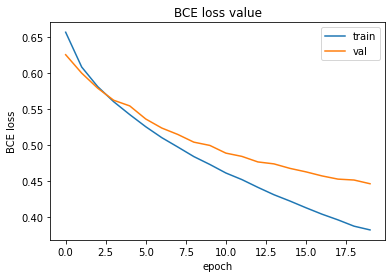

In [57]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

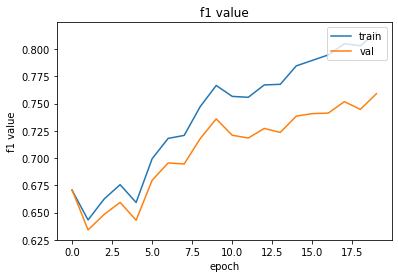

In [58]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [59]:
fp, fn, tp, tn, accuracy, precision, recall = predict(model, val_iterator)

In [60]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.7567
precision: 0.762782401902497
recall: 0.7569321533923303


In [124]:
best_acc = 0
emb_val = ''

for emb in [5, 10, 20, 50, 100]:
#  for lr in [0.0005, 0.001, 0.01, 0.1]:
    model = CNN(len(word2id), emb)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.BCELoss()  

    # веса модели и значения лосса храним там же, где и все остальные тензоры
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(10):
        print(f'starting Epoch {i}')
        epoch_loss = train(model, train_iterator, optimizer, criterion, print_v=False)
        losses.append(epoch_loss)
        f1_on_train,_ = evaluate(model, train_iterator, criterion, print_v=False)
        f1s.append(f1_on_train)
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, print_v=False)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
    fp, fn, tp, tn, accuracy, precision, recall = predict(model, val_iterator)
    print(f'results for embedding_size={emb}')
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    if accuracy > best_acc:
      best_acc = accuracy
      emb_val = emb
print(f'____________________________________________')
print(f'best accuracy is {best_acc} for emb_size {emb_val}')

starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for embedding_size=5
accuracy: 0.6986
precision: 0.7113446279219386
recall: 0.665396188565697
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for embedding_size=10
accuracy: 0.7302
precision: 0.7198615650836377
recall: 0.7510531594784353
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for embedding_size=20
accuracy: 0.7537
precision: 0.7573469387755102
recall: 0.7444332998996991
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results fo

In [127]:
best_acc = 0
lr_val = ''

for lr in [0.0005, 0.001, 0.005, 0.01, 0.05]:
    model = CNN(len(word2id), emb_val)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()  

    # веса модели и значения лосса храним там же, где и все остальные тензоры
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(10):
        print(f'starting Epoch {i}')
        epoch_loss = train(model, train_iterator, optimizer, criterion, print_v=False)
        losses.append(epoch_loss)
        f1_on_train,_ = evaluate(model, train_iterator, criterion, print_v=False)
        f1s.append(f1_on_train)
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, print_v=False)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
    fp, fn, tp, tn, accuracy, precision, recall = predict(model, val_iterator)
    print(f'results for lr={lr}')
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    if accuracy > best_acc:
      best_acc = accuracy
      lr_val = lr
print(f'____________________________________________')
print(f'best accuracy is {best_acc} for lr {lr_val}')

starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr=0.0005
accuracy: 0.7858
precision: 0.7672494829855236
recall: 0.8186559679037111
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr=0.001
accuracy: 0.7999
precision: 0.7857142857142857
recall: 0.8230692076228686
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr=0.005
accuracy: 0.8163
precision: 0.799125807677689
recall: 0.843530591775326
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr=0.01
accuracy: 0.8168

In [131]:
model = CNN(len(word2id), emb_val)
optimizer = optim.Adam(model.parameters(), lr=lr_val)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'starting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion, print_v=False)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion, print_v=False)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, print_v=False)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
fp, fn, tp, tn, accuracy, precision, recall = predict(model, val_iterator)
print('Значения после подбора гипепараметров:')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
starting Epoch 10
starting Epoch 11
starting Epoch 12
starting Epoch 13
starting Epoch 14
starting Epoch 15
starting Epoch 16
starting Epoch 17
starting Epoch 18
starting Epoch 19
Значения после подбора гипепараметров:
accuracy: 0.8195
precision: 0.8011363636363636
recall: 0.8485456369107321


In [68]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['Еще не совсем, но у меня это в планах :) :) :)', 'наш по скорее', 'RT Кировский район в твиттере только и делает, что желает доброго утра)))', 'с моим чувством юмора я ничего комментировать не ))', 'у миня тут одна ток шлюшка :D', 'RT Браво! растёт на одном только острове - Редкий и себе привезла и друзьям', 'Я после', '@CakeeDean Добрый День МИЛАЯ :*', 'Просыпаться в понедельник в 9:30 просто прекрасно)))', '@angel_kimki да:) ахахах)) а вообще можно', 'ну если что пиши', 'зато видно, что ты своего дела! :DDDD', 'меня меня меня', 'реклама была и сказали что 12 числа будет', 'Добра тебе)', 'С девочками покупали мандаринки и прочие За одно и погуляли, меня подруга в весело*', 'На работе рекламная акция Взяли себе пять )))', '#HappyVIrthday #np - Вот что делает меня счастливой :)))))', 'сахар тоже. И И И Наверное, мысль ясна :)', 'Такая красивая девушка в с на', 'вчера слушал тоже в машине, старый рок )', 'Хрень какая-то, но идея интересная :)', 'как будто в

In [69]:
print('ошибочно не относим к фамилиям:', fn[:100])

ошибочно не относим к фамилиям: ['RT друзья, летит из во в ближайшее время? за', 'кто войну и мир" теперь не боится', 'седня была на я на права и пздц я не', 'ты чего так рано?', 'я даже боюсь представить что у тебя там... Наверное в прячешь целое :DD', 'Всё-таки засирать лс очень круто) 101 сообщение, не никакого смысла, конечно, немного, но для начала норм) Как-то', 'сперва я думала,что они очень моя подруга сразу подвох после случая в вк, так тем', 'Я КАК Я ДАЖЕ НЕ БУДУ ЭТО [2]', 'сначала я думал сейчас начал фишку', 'такая вот', 'не хочется но предложила продолжить традицию московских только,что пока ничего не предвидится', 'Надо делать видео для А да Смотрю', 'День не очень удался сегодня, но сейчас я круто а всё потому что меня главный спасибо от', 'RT @zackforex: уже и Киев скоро людьми. не', 'я видела трейлер просто', 'RT Получил винил на почте и иду улыбаюсь как', 'RT @_Nikita_Horan_ не за что, своих не', 'Желание уголок почти теперь можно по делам идти)', 'Спасибо,что меня от

In [70]:
print('ошибочно считаем фамилиями:', fp[:100])

ошибочно считаем фамилиями: ['Последние дни я на', 'В 8:00 моя всьо буде нормально!', 'никакого настроения. хочу просто целый день лежать на полу и Хотелось чего-то но, ты не умеешь так', 'RT Говорят если у человека к нуждается в любви. А я вот думал, что он просто жрать сладкое', 'Его имя и он,навсегда останутся в моем сердце!(((', 'не могу его не даст мне спать(((', 'С в одной машине сегодня :33', 'действительно, тебе лучше пить только на нг', 'почему те люди которые мне нужны и редко заходят в соц', 'даааа мне совмещать и алкоголь', 'RT ну так не интересно! Я на игру(', '@batzorig2012 Одоо тэгвэл л гаргах дээ ((-: @HaliunaaTs', 'звезда', 'каблуки 20 см куплю и сразу(', 'Я хочу к брату не более его проблемы не дают нам всем', 'буду( я всегда буду скучать пока ты не будешь рядом со мной', 'Даже пирожки вкусно пахнут тогда как я на #боль', 'Там как раз ВЫ ТАКИЕ ОТ ЭТОЙ !!!!! И тот неловкий момент, когда', 'Наверно я скоро выучу все даты на которых мне не суждено', 'RT Последний магазин

In [64]:
import gensim
texts = all_tweets_data.text.apply(preprocess).tolist()
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1)

In [65]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [66]:
class CNN_w2v(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv =  nn.Conv1d(in_channels=180, out_channels=50, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=50, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = self.conv(torch.cat((feature_map_bigrams, feature_map_trigrams), 1))
        pooling = concat.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [67]:
model_w2v = CNN_w2v(len(word2id), 8)
optimizer = optim.Adam(model_w2v.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model_w2v = model_w2v.to(DEVICE)
criterion = criterion.to(DEVICE)

In [68]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_w2v, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_w2v, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_w2v, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7262892462313175
Train loss: 0.6944870840419423
Train loss: 0.6816103887557984
Train loss: 0.6714405550885556
Train loss: 0.6644368150404522

Evaluating on train...
Val loss: 0.6701085120439529, Val f1: 0.6710220575332642
Val loss: 0.6491085868893247, Val f1: 0.6545130610466003
Val loss: 0.6423030161857605, Val f1: 0.6481454372406006
Val loss: 0.6397659787491187, Val f1: 0.6439507603645325
Val loss: 0.6372197589703968, Val f1: 0.6433106064796448

Evaluating on test...
Val loss: 1.2680591940879822, Val f1: 1.2662785053253174
Val loss: 0.8451773126920065, Val f1: 0.8381778597831726
Val loss: 0.7566016793251038, Val f1: 0.7652910351753235
Val loss: 0.7205219779695783, Val f1: 0.7321568131446838
Val loss: 0.7015093631214566, Val f1: 0.7106819152832031

starting Epoch 1
Training...
Train loss: 0.6677677929401398
Train loss: 0.6451104789069204
Train loss: 0.6347089183330535
Train loss: 0.6289643022551465
Train loss: 0.6235407236076537

Evaluating o

In [71]:
fp, fn, tp, tn, accuracy, precision, recall = predict(model_w2v, val_iterator)

In [72]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.7652
precision: 0.7675464320625611
recall: 0.7720747295968535


In [73]:
class TweetsDataset_2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        id_words = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        id_symbols= torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return id_words, id_symbols, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      id_words, id_symbols, y = list(zip(*batch))
      padded_id_words = pad_sequence(id_words, batch_first=True).to(self.device)
      padded_id_symbols = pad_sequence(id_symbols, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_id_words, padded_id_symbols, y

In [74]:
val_dataset = TweetsDataset_2(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [75]:
train_dataset = TweetsDataset_2(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [76]:
train_iterator

In [77]:
batch = next(iter(train_iterator))
batch[1].shape

torch.Size([1024, 140])

In [78]:
class CNN_2(nn.Module):
    
    def __init__(self, vocab_size_word, vocab_size_symbol, embedding_dim):
        super().__init__()
        self.embedding_word = nn.Embedding(vocab_size_word, embedding_dim)
        self.embedding_word.from_pretrained(torch.tensor(weights), freeze=True)
        self.embedding_symbol = nn.Embedding(vocab_size_symbol, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, text, word):
        embedded_words = self.embedding_word(text)
        embedded_symbols = self.embedding_symbol(word)
        embedded_words = embedded_words.transpose(1,2)
        embedded_symbols = embedded_symbols.transpose(1,2)
        feature_map_bigrams = self.pooling(self.bigrams(embedded_symbols)).max(2)[0] 
        feature_map_trigrams = self.pooling(self.trigrams(embedded_symbols)).max(2)[0] 
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [79]:
model_2 = CNN_2(len(word2id), len(symbol2id), 8)
optimizer = optim.Adam(model_2.parameters(), lr=0.0005)
criterion = nn.BCELoss()  
model_2 = model_2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [103]:
def train(model, iterator, optimizer, criterion, print_v=True):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов
    for i, (texts, words, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts, words)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if print_v==True:
          if not (i + 1) % int(len(iterator)/5):
              print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [104]:
def evaluate(model, iterator, criterion, print_v=True):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, words, ys) in enumerate(iterator):   
            preds = model(texts, words)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if print_v==True:
              if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [86]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_2, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_2, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7295184694230556
Train loss: 0.7032984874465249
Train loss: 0.6924043822288514
Train loss: 0.685340194559809
Train loss: 0.6794215532995406

Evaluating on train...
Val loss: 0.6904056183993816, Val f1: 0.6504154205322266
Val loss: 0.66978919506073, Val f1: 0.631404459476471
Val loss: 0.6627586233615875, Val f1: 0.6246640086174011
Val loss: 0.6601835907395206, Val f1: 0.6192572712898254
Val loss: 0.6582370840367817, Val f1: 0.6172813177108765

Evaluating on test...
Val loss: 1.3064852356910706, Val f1: 1.2085943222045898
Val loss: 0.8659918506940206, Val f1: 0.8139581084251404
Val loss: 0.7816905617713928, Val f1: 0.7229977250099182
Val loss: 0.7452020389693124, Val f1: 0.6895936131477356
Val loss: 0.7248063219918145, Val f1: 0.6661089062690735

starting Epoch 1
Training...
Train loss: 0.686821598559618
Train loss: 0.6605262756347656
Train loss: 0.6460525286197663
Train loss: 0.6342212086293235
Train loss: 0.6221410206386021

Evaluating on tra

In [100]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, words, ys) in enumerate(iterator):   
            preds = model(texts, words)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    accuracy = (len(tp)+len(tn))/(len(tp)+len(fp)+len(fn)+len(tn))
    precision = len(tp)/(len(tp)+len(fp))
    recall = len(tp)/(len(tp)+len(fn))
    return fp, fn, tp, tn, accuracy, precision, recall

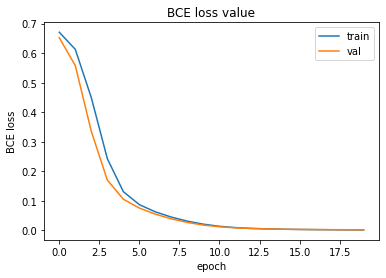

In [88]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

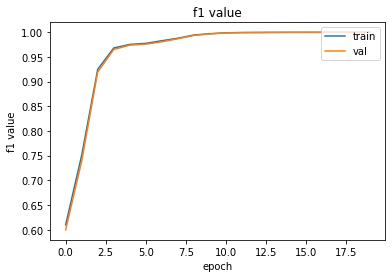

In [89]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [90]:
fp, fn, tp, tn, accuracy, precision, recall = predict(model_2, val_iterator)

In [91]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9994
precision: 0.9990174887011201
recall: 0.999803343166175


In [94]:
import re
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [95]:
vocab_sym = Counter()
for text in tweets_data['text']:
    vocab_sym.update(preprocess1(preprocess_text(text)))
print('всего уникальных токенов:', len(vocab_sym))

filtered_vocab_sym = set()

for symbol in vocab_sym:
    if vocab_sym[symbol] > 5:
        filtered_vocab_sym.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_sym))

symbol2id = {'PAD':0}

for symbol in filtered_vocab_sym:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

всего уникальных токенов: 73
уникальных символов, втретившихся больше 5 раз: 73


In [96]:
val_dataset = TweetsDataset_2(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

train_dataset = TweetsDataset_2(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

batch = next(iter(train_iterator))

In [98]:
model_2 = CNN_2(len(word2id), len(symbol2id), 8)
optimizer = optim.Adam(model_2.parameters(), lr=0.0005)
criterion = nn.BCELoss()  
model_2 = model_2.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_2, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_2, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.749869029968977
Train loss: 0.717858663111022
Train loss: 0.705201164484024
Train loss: 0.6983190419068978
Train loss: 0.6931087275346121

Evaluating on train...
Val loss: 0.7120740450918674, Val f1: 0.6139716506004333
Val loss: 0.6898128697366426, Val f1: 0.5977404117584229
Val loss: 0.683194522857666, Val f1: 0.5898994207382202
Val loss: 0.6804384375686077, Val f1: 0.5856269598007202
Val loss: 0.678553078855787, Val f1: 0.5837620496749878

Evaluating on test...
Val loss: 1.3426162004470825, Val f1: 1.135582447052002
Val loss: 0.8935660918553671, Val f1: 0.7708638906478882
Val loss: 0.8060264348983764, Val f1: 0.6840042471885681
Val loss: 0.7676125594547817, Val f1: 0.6538643836975098
Val loss: 0.7461747858259413, Val f1: 0.6361759901046753

starting Epoch 1
Training...
Train loss: 0.712755598127842
Train loss: 0.6892282131946448
Train loss: 0.6803616893291473
Train loss: 0.6753336342413034
Train loss: 0.6720490725267501

Evaluating on train

In [102]:
fp, fn, tp, tn, accuracy, precision, recall = predict(model_2, val_iterator)
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.6665
precision: 0.6565295169946332
recall: 0.7217305801376598


In [111]:
best_acc = 0
lr_val = ''

for lr in [0.0005, 0.001, 0.005, 0.01, 0.05]:
    model_2 = CNN_2(len(word2id), len(symbol2id), 8)
    optimizer = optim.Adam(model_2.parameters(), lr=lr)
    criterion = nn.BCELoss()  

    # веса модели и значения лосса храним там же, где и все остальные тензоры
    model_2 = model_2.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(10):
        print(f'starting Epoch {i}')
        epoch_loss = train(model_2, train_iterator, optimizer, criterion, print_v=False)
        losses.append(epoch_loss)
        f1_on_train,_ = evaluate(model_2, train_iterator, criterion, print_v=False)
        f1s.append(f1_on_train)
        f1_on_test, epoch_loss_on_test = evaluate(model_2, val_iterator, criterion, print_v=False)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)

    fp, fn, tp, tn, accuracy, precision, recall = predict(model_2, val_iterator)
    print(f'results for lr {lr}')
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    if accuracy > best_acc:
      best_acc = accuracy
      lr_val = lr
print(f'____________________________________________')
print(f'best accuracy is {best_acc} for lr {lr_val}')

starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr 0.0005
accuracy: 0.6483
precision: 0.6649137568363483
recall: 0.6216322517207473
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr 0.001
accuracy: 0.6636
precision: 0.6787123572170302
recall: 0.6426745329400196
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr 0.005
accuracy: 0.6836
precision: 0.6566628608709836
recall: 0.791740412979351
starting Epoch 0
starting Epoch 1
starting Epoch 2
starting Epoch 3
starting Epoch 4
starting Epoch 5
starting Epoch 6
starting Epoch 7
starting Epoch 8
starting Epoch 9
results for lr 0.01
accuracy: 0.686

In [114]:
model_2 = CNN_2(len(word2id), len(symbol2id), 8)
optimizer = optim.Adam(model_2.parameters(), lr=0.01)
criterion = nn.BCELoss()  
model_2 = model_2.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(19):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_2, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_2, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.8855736292898655
Train loss: 0.780337778004733
Train loss: 0.74134920835495
Train loss: 0.7206962037442336
Train loss: 0.7067776499759584

Evaluating on train...
Val loss: 0.6867129094898701, Val f1: 0.6478328108787537
Val loss: 0.6650897372852672, Val f1: 0.6259854435920715
Val loss: 0.6582334089279175, Val f1: 0.6201726198196411
Val loss: 0.6553518184975012, Val f1: 0.6169167757034302
Val loss: 0.6529026443050021, Val f1: 0.6160329580307007

Evaluating on test...
Val loss: 1.2900512218475342, Val f1: 1.220392107963562
Val loss: 0.8577924569447836, Val f1: 0.8196989893913269
Val loss: 0.7776997447013855, Val f1: 0.7232353091239929
Val loss: 0.7411121215139117, Val f1: 0.6890925168991089
Val loss: 0.7208931512302823, Val f1: 0.6689637303352356

starting Epoch 1
Training...
Train loss: 0.6832228563725948
Train loss: 0.6627730600761644
Train loss: 0.6575409841537475
Train loss: 0.652228824238279
Train loss: 0.6475767550014314

Evaluating on tra

In [115]:
fp, fn, tp, tn, accuracy, precision, recall = predict(model_2, val_iterator)
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.6934
precision: 0.6750476851049072
recall: 0.7655850540806293
